# 1. Downloading images

![Example](img/example1.jpg)

## Introduction
This notebook provides a step-by-step guide to building an instance segmentation model using Azure AutoML for Images. It is designed to help data scientists and engineers streamline the process of training, tuning, and deploying computer vision models without extensive manual configuration.
Key highlights include:

- Environment Setup: Configure Azure ML workspace, compute resources, and dependencies.
- Data Preparation: Load and preprocess image datasets for segmentation tasks.
- Automated Training: Leverage AutoML to optimize hyperparameters and improve model performance.
- Experiment Tracking: Use MLflow integration for monitoring and reproducibility.
- Visualization: Display segmentation outputs with Matplotlib and OpenCV for quick evaluation.

## AutoML process
![Example](img/automlprocess.png)

## Documentation
- https://learn.microsoft.com/en-us/azure/machine-learning/concept-automated-ml#computer-vision-preview
- https://learn.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?view=azureml-api-2&tabs=cli#supported-model-architectures

## Tutorials & Notebooks
- https://github.com/Azure/azureml-examples/blob/main/sdk/python/jobs/automl-standalone-jobs/automl-image-instance-segmentation-task-fridge-items/automl-image-instance-segmentation-task-fridge-items.ipynb

In [1]:
import datetime
import matplotlib.pyplot as plt
import os
import pandas as pd
import platform
import psutil
import random
import requests
import shutil
import sys
import time
import zipfile

from pathlib import Path
from PIL import Image
from typing import List, Dict

## 1. Informations and settings

In [ ]:
IMAGES_DIR = "images"

os.makedirs(IMAGES_DIR, exist_ok=True)

## 2. Helper

In [3]:
def download_dropbox_file(dropbox_url, output_filename):
    """
    Download a file from Dropbox shared link
    
    Args:
        dropbox_url: The Dropbox shared link
        output_filename: Name to save the downloaded file
    """
    if 'www.dropbox.com' in dropbox_url:
        download_url = dropbox_url.replace('www.dropbox.com', 'dl.dropboxusercontent.com')
        download_url = download_url.replace('?dl=0', '')
    else:
        download_url = dropbox_url
    
    # Download the file
    print(f"📥 Downloading images zip file from: {download_url}")
    print("Please wait...\n")
    response = requests.get(download_url, stream=True)
    
    if response.status_code == 200:
        with open(output_filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"✅ File downloaded successfully: {output_filename}")
        !ls $output_filename -lh
    else:
        print(f"❌ Failed to download. Status code: {response.status_code}")

In [4]:
def display_random_images(image_dir, num_images=15, images_per_row=5):
    """
    Display random images from a directory in a grid layout.
    
    Parameters:
    - image_dir: path to the directory containing images
    - num_images: total number of images to display
    - images_per_row: number of images per row
    """
    # Get all image files from the directory
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff'}
    image_files = [f for f in os.listdir(image_dir) 
                   if os.path.splitext(f.lower())[1] in valid_extensions]
    
    # Select random images
    num_images = min(num_images, len(image_files))
    selected_images = random.sample(image_files, num_images)
    
    # Calculate number of rows needed
    num_rows = (num_images + images_per_row - 1) // images_per_row
    
    # Create the plot
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))
    
    # Flatten axes array for easier iteration
    if num_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    # Display images
    for idx, img_file in enumerate(selected_images):
        img_path = os.path.join(image_dir, img_file)
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(img_file, fontsize=10)
    
    # Hide any unused subplots
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

In [5]:
def get_aspect_ratio(ar):
    """
    Convert a numeric aspect ratio into a human-readable string.

    This function compares the given aspect ratio (`ar`) to a set of common
    aspect ratios (e.g., 16:9, 4:3, 3:2, 1:1, 21:9). If the provided ratio
    is within 0.01 of one of these common ratios, it returns the corresponding
    label (e.g., "16:9"). Otherwise, it returns the ratio formatted as
    "<value>:1" with two decimal places.

    Parameters
    ----------
    ar : float
        The aspect ratio to evaluate (typically width / height).

    Returns
    -------
    str
        A string representing the aspect ratio, either as a common label
        (e.g., "16:9") or in the format "<ratio>:1" (e.g., "1.78:1").
    """
    common_ratios = {
        (16, 9): "16:9",
        (4, 3): "4:3",
        (3, 2): "3:2",
        (1, 1): "1:1",
        (21, 9): "21:9"
    }
    
    for (w, h), label in common_ratios.items():
        if abs(ar - w/h) < 0.01:
            return label
    return f"{ar:.2f}:1"

In [6]:
def get_df_images(images_dir: str) -> List[Dict]:
    """
    Collect metadata from JPEG images in the specified directory.
    """
    images_path = Path(images_dir)
    valid_extensions = {'.jpg', '.jpeg', '.gif', '.bmp'}
    data = []
    
    # Use glob for more efficient file filtering
    for file_path in images_path.glob('*'):
        if not file_path.is_file() or file_path.suffix.lower() not in valid_extensions:
            continue
            
        try:
            file_stats = file_path.stat()
            size_mb = file_stats.st_size / (1024 * 1024)
            timestamp = datetime.datetime.fromtimestamp(file_stats.st_mtime)
            
            with Image.open(file_path) as img:
                width, height = img.size

            wh = width * height
            megapixels = wh / 1_000_000
            total_pixels = f'{wh:,} ({megapixels:.1f} MP)'
            aspect_ratio = get_aspect_ratio(width / height)
            img_format = img.format
            color_mode = img.mode

            data.append({
                "image_file": file_path.name,
                "size_mb": round(size_mb, 2),
                "width": width,
                "height": height,
                "resolution": f"{width}x{height}",
                "total_pixels": total_pixels,
                "aspect_ratio": aspect_ratio,
                "image_format": img_format,
                "color_mode": color_mode,
                "date": timestamp.date(),
                "time": timestamp.time(),
            })
            
        except (OSError, IOError) as e:
            print(f"Warning: Could not process {file_path.name}: {e}")
            continue
    
    return pd.DataFrame(data)

## 3. Images

### 3.1 Downloading images files

In [7]:
dropbox_link = "https://www.dropbox.com/scl/fi/3oo8kcumnusy8ulc8pi8y/streetview_images.zip?rlkey=gtzqux3wlofpyic7bm5ewvx06&st=dc8iedb1&dl=0"

In [8]:
zip_file = os.path.join(IMAGES_DIR, "streetview_images.zip")

In [9]:
start = time.time()
download_dropbox_file(dropbox_link, zip_file)

minutes, seconds = divmod((time.time() - start), 60)
print(f"\n✅ Done in {seconds:.0f} seconds")

📥 Downloading images zip file from: https://dl.dropboxusercontent.com/scl/fi/3oo8kcumnusy8ulc8pi8y/streetview_images.zip?rlkey=gtzqux3wlofpyic7bm5ewvx06&st=dc8iedb1&dl=0
Please wait...

✅ File downloaded successfully: images_segmentation/streetview_images.zip
-rwxrwxrwx 1 root root 339M Feb 12 07:29 images_segmentation/streetview_images.zip

✅ Done in 7 seconds


In [10]:
start = time.time()

print(f"Unzipping zip images file '{zip_file}'...")

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('')

minutes, seconds = divmod((time.time() - start), 60)
print(f"✅ Done in {minutes:.0f} minutes and {seconds:.0f} seconds")

Unzipping zip images file 'images_segmentation/streetview_images.zip'...
✅ Done in 1 minutes and 30 seconds


In [11]:
print(f"Deleting zip images file '{zip_file}'...")

if os.path.exists(zip_file):
    try:
        os.remove(zip_file)
        print(f"✅ Done: Zip file '{zip_file}' is deleted.")
    except Exception as e:
        print(f"❌ Error deleting file: {e}")
else:
    print(f"⚠️ File '{zip_file}' does not exist.")

Deleting zip images file 'images_segmentation/streetview_images.zip'...
✅ Done: Zip file 'images_segmentation/streetview_images.zip' is deleted.


### 3.2 Some images

Image file: images_segmentation/SSDB00001.JPG


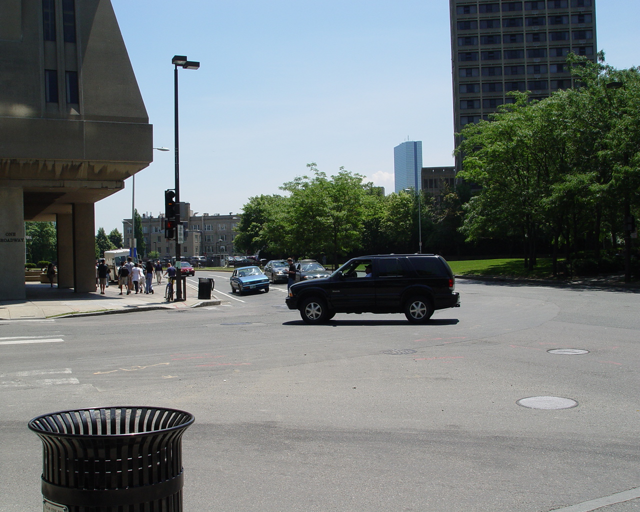

In [17]:
image_file = os.path.join(IMAGES_DIR, "SSDB00001.JPG")

print(f"Image file: {image_file}")
img = Image.open(image_file)
img.resize((640, 512))

In [18]:
width, height = img.size
aspect_ratio = width / height
total_pixels = width * height
megapixels = total_pixels / 1_000_000

file_size = os.path.getsize(image_file)
file_size_mb = file_size / (1024 * 1024)
size_info = f"  💾 File size: {file_size_mb:.2f} MB"
aspect_str = get_aspect_ratio(aspect_ratio)

print(f"""
📸 Image Information: '{os.path.basename(image_file)}'
  📏 Dimensions: {width:,} × {height:,} pixels
  🔢 Total pixels: {total_pixels:,} ({megapixels:.1f} MP)
  📐 Aspect ratio: {aspect_str}
  📄 Format: {img.format}
  🎨 Color mode: {img.mode}
{size_info}
""")


📸 Image Information: 'SSDB00001.JPG'
  📏 Dimensions: 1,280 × 960 pixels
  🔢 Total pixels: 1,228,800 (1.2 MP)
  📐 Aspect ratio: 4:3
  📄 Format: JPEG
  🎨 Color mode: RGB
  💾 File size: 0.57 MB



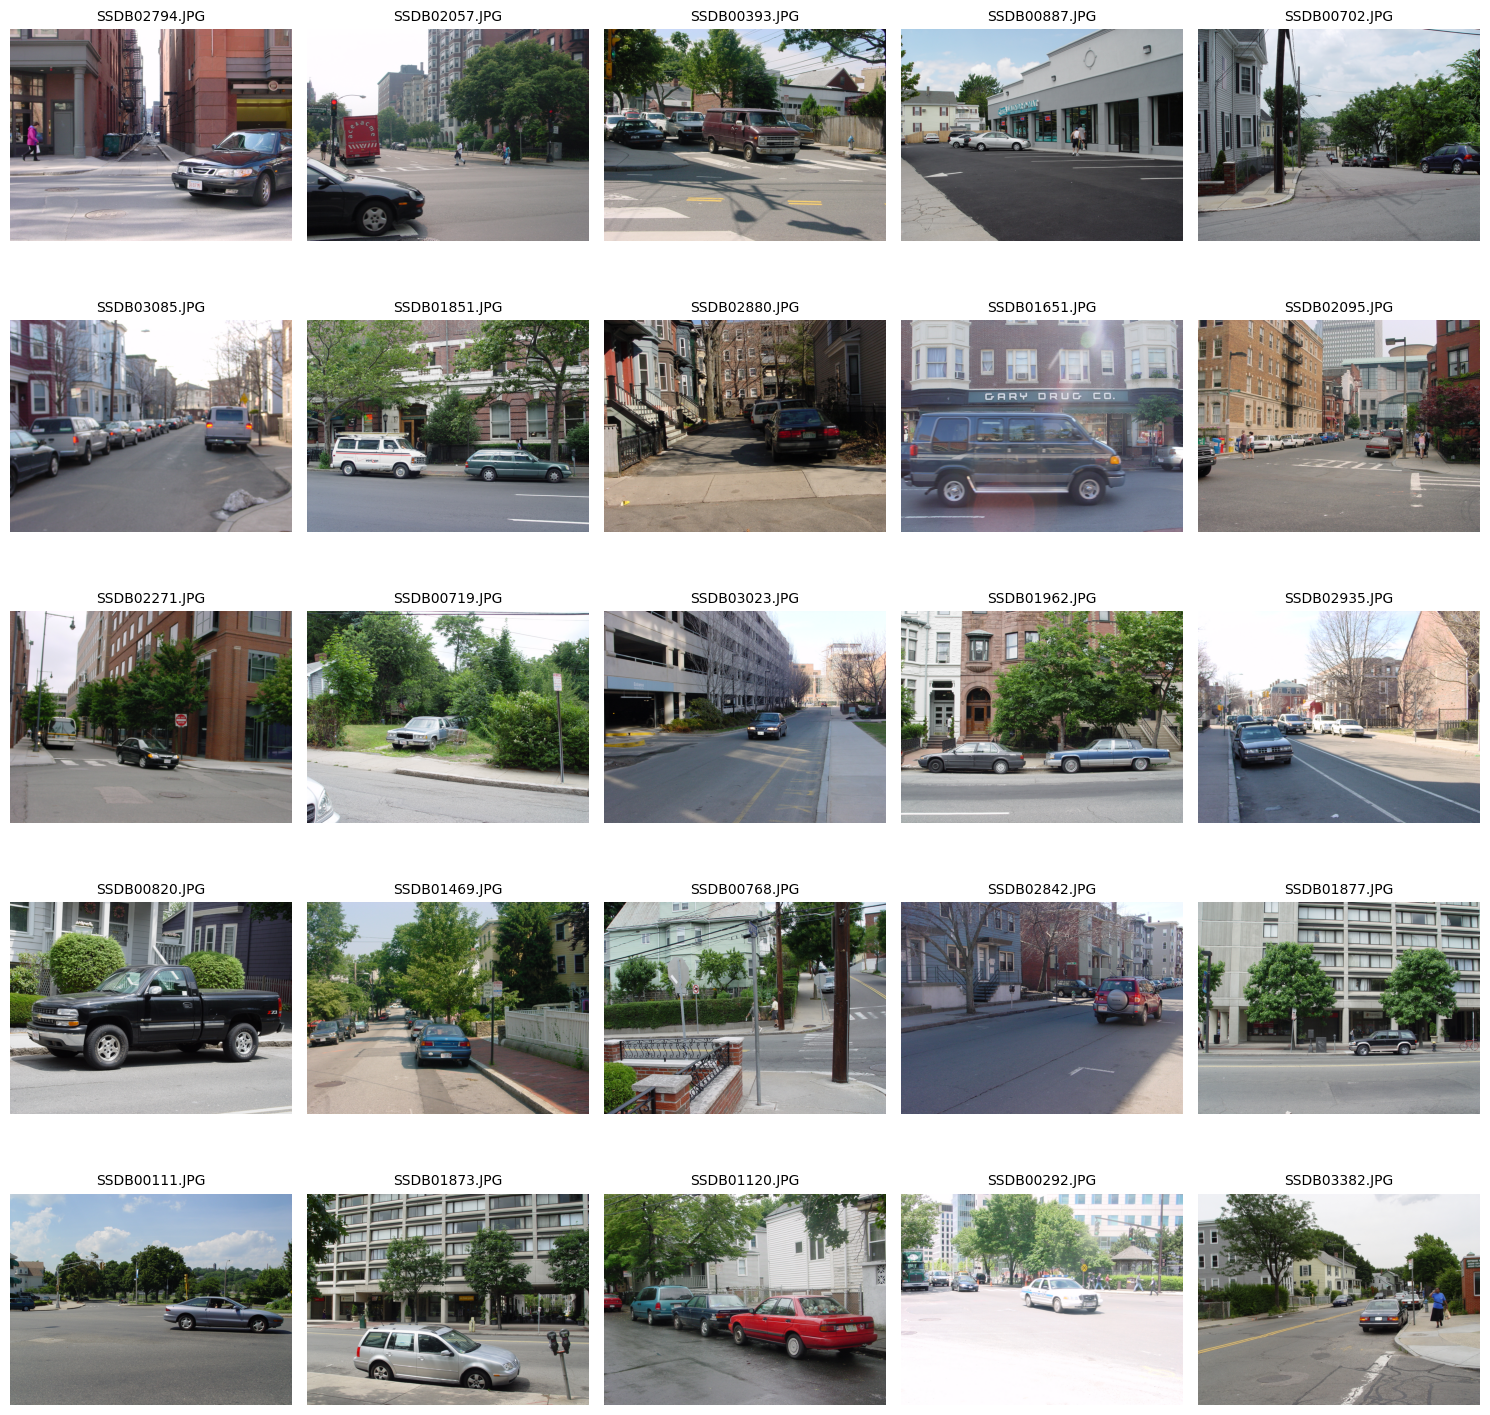

In [20]:
display_random_images(IMAGES_DIR, num_images=25, images_per_row=5)

In [21]:
df = get_df_images(IMAGES_DIR)
print(f"📸 Total number of images = {len(df)}")

📸 Total number of images = 600


In [22]:
df

image_file  size_mb  width  height resolution        total_pixels  \
0    SSDB00001.JPG     0.57   1280     960   1280x960  1,228,800 (1.2 MP)   
1    SSDB00002.JPG     0.57   1280     960   1280x960  1,228,800 (1.2 MP)   
2    SSDB00030.JPG     0.56   1280     960   1280x960  1,228,800 (1.2 MP)   
3    SSDB00038.JPG     0.58   1280     960   1280x960  1,228,800 (1.2 MP)   
4    SSDB00042.JPG     0.57   1280     960   1280x960  1,228,800 (1.2 MP)   
..             ...      ...    ...     ...        ...                 ...   
595  SSDB03527.JPG     0.53   1280     960   1280x960  1,228,800 (1.2 MP)   
596  SSDB03530.JPG     0.52   1280     960   1280x960  1,228,800 (1.2 MP)   
597  SSDB03534.JPG     0.57   1280     960   1280x960  1,228,800 (1.2 MP)   
598  SSDB03542.JPG     0.58   1280     960   1280x960  1,228,800 (1.2 MP)   
599  SSDB03546.JPG     0.57   1280     960   1280x960  1,228,800 (1.2 MP)   

    aspect_ratio image_format color_mode        date             time  
0            4:3         JPEG        RGB  2026-02-12  07:52:10.707063  
1            4:3         JPEG        RGB  2026-02-12  07:52:10.739044  
2            4:3         JPEG        RGB  2026-02-12  07:52:10.742043  
3            4:3         JPEG        RGB  2026-02-12  07:52:10.696069  
4            4:3         JPEG        RGB  2026-02-12  07:52:10.741045  
..           ...          ...        ...         ...              ...  
595          4:3         JPEG        RGB  2026-02-12  07:53:49.452239  
596          4:3         JPEG        RGB  2026-02-12  07:53:49.569172  
597          4:3         JPEG        RGB  2026-02-12  07:53:49.682109  
598          4:3         JPEG        RGB  2026-02-12  07:53:49.972944  
599          4:3         JPEG        RGB  2026-02-12  07:53:50.171832  

[600 rows x 11 columns]

In [23]:
df.describe()

size_mb   width  height
count  600.000000   600.0   600.0
mean     0.564167  1280.0   960.0
std      0.028752     0.0     0.0
min      0.490000  1280.0   960.0
25%      0.550000  1280.0   960.0
50%      0.570000  1280.0   960.0
75%      0.580000  1280.0   960.0
max      0.930000  1280.0   960.0

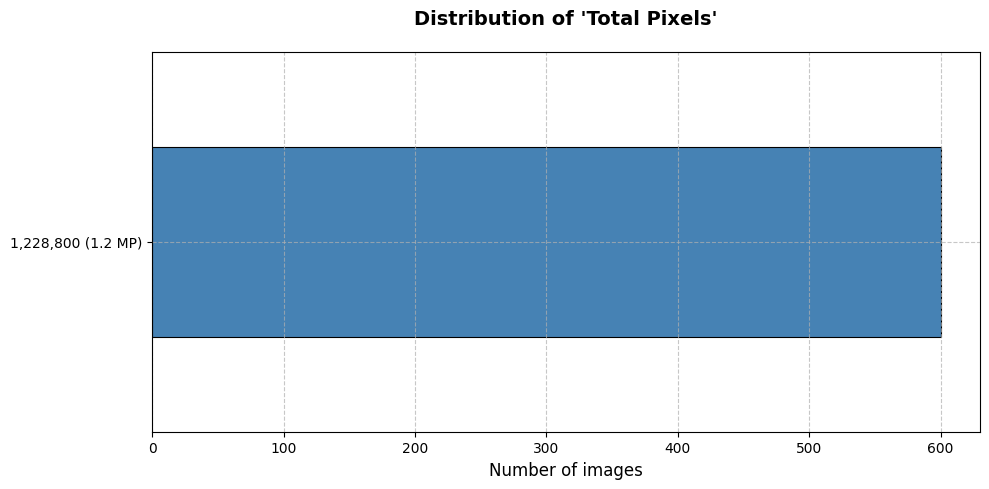

In [24]:
ax = df['total_pixels'].value_counts(sort=True).plot.barh(
    figsize=(10, 5),
    color='steelblue',
    edgecolor='black',
    linewidth=0.8,
)

ax.set_title("Distribution of 'Total Pixels'", fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Number of images', fontsize=12)
plt.grid(axis='y', alpha=0.7, linestyle='--')
plt.grid(axis='x', alpha=0.7, linestyle='--')
plt.tight_layout()

plt.show()

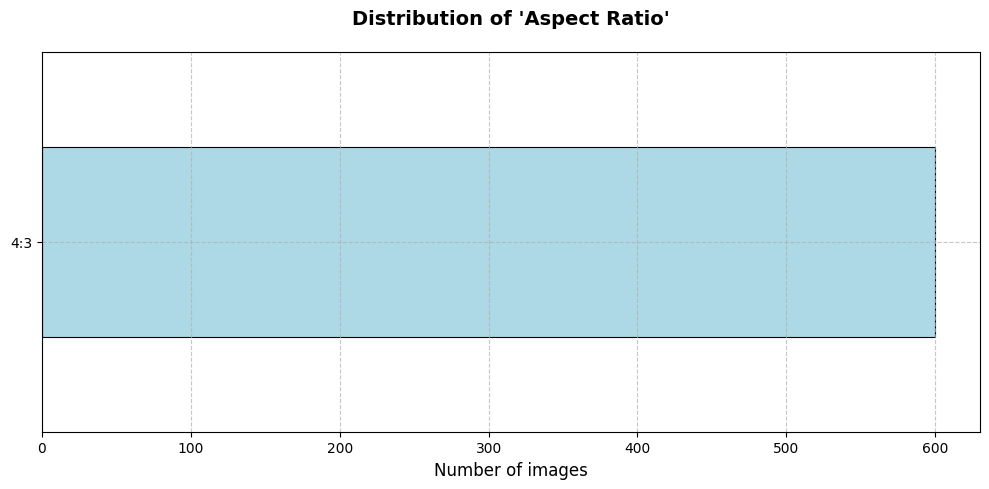

In [25]:
ax = df['aspect_ratio'].value_counts(sort=True).plot.barh(
    figsize=(10, 5),
    color='lightblue',
    edgecolor='black',
    linewidth=0.8,
)

ax.set_title("Distribution of 'Aspect Ratio'", fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Number of images', fontsize=12)
plt.grid(axis='y', alpha=0.7, linestyle='--')
plt.grid(axis='x', alpha=0.7, linestyle='--')
plt.tight_layout()

plt.show()

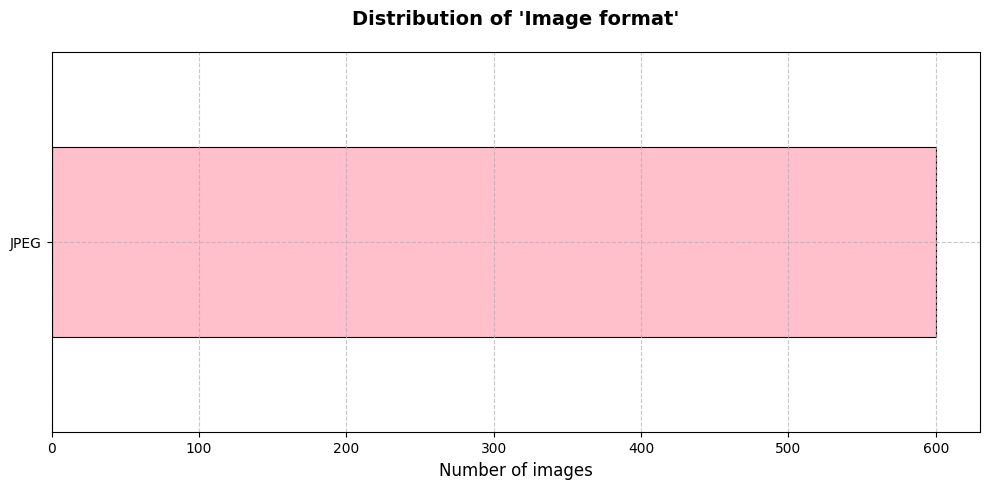

In [26]:
ax = df['image_format'].value_counts(sort=True).plot.barh(
    figsize=(10, 5),
    color='pink',
    edgecolor='black',
    linewidth=0.8,
)

ax.set_title("Distribution of 'Image format'", fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Number of images', fontsize=12)
plt.grid(axis='y', alpha=0.7, linestyle='--')
plt.grid(axis='x', alpha=0.7, linestyle='--')
plt.tight_layout()

plt.show()

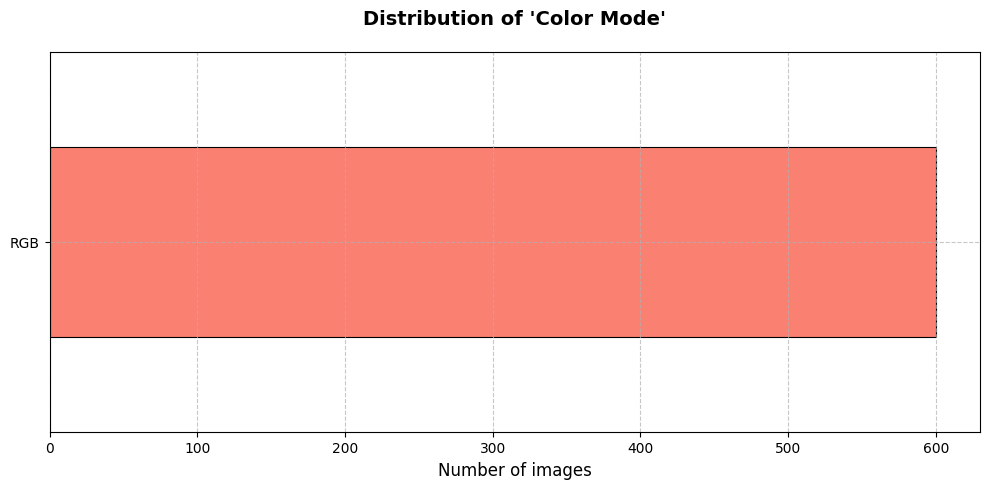

In [27]:
ax = df['color_mode'].value_counts(sort=True).plot.barh(
    figsize=(10, 5),
    color='salmon',
    edgecolor='black',
    linewidth=0.8,
)

ax.set_title("Distribution of 'Color Mode'", fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Number of images', fontsize=12)
plt.grid(axis='y', alpha=0.7, linestyle='--')
plt.grid(axis='x', alpha=0.7, linestyle='--')
plt.tight_layout()

plt.show()